# Plot surface effect; and compute attenuation factor $B(\omega)$
2021.10.05 Kurama Okubo

Summary plots for the directionality of sensors including surface effect. This note book is modifed from `SensorCoupling_BallDrop/code/08_plot_surfaceeffect_result_Case2.ipynb`.

- 2022.1.5 plot schematic
- 2022.11.25 update for new ball-drop test
- 2024.1.24 update for master plot; plotting Case 2 with the threshold of multiple P arrival with large incident angle.
- 2024.7.17 update to compute attenuation factor B(ω).
- 2024.7.18 update to apply smoothing on the spectra.
- 2025.3.16 update for master plot. Clean up the notebook.


In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec
from obspy.signal.cross_correlation import correlate, xcorr_max

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 9
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [2]:
# Directory for picked waveforms
rootdir = "../../SensorCoupling_BallDrop/code/"
# bdwaveform_datadir = rootdir+"../data/DATA_greencomparison"
bdwaveform_datadir = "../data/DATA_greencomparison" # use the longer pretrigger for observation noise

# channel table
channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# source location
source_finame = rootdir+'../data/balldrop_events_isocoord.csv'

In [3]:
figdir = "../figure/debug_08_surfaceeffect_casestudy/Case2_schematic/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:
root=rootdir+"../data/DATA_surfaceeffect_Aij_Case2/" # read the coupling coefficient from the original datasheet

In [5]:
# read PAZ scaling factor as the gain k_{PAZ}
# parameters for instrumental response removal
PAZ_case = "fronttop"
# D = sio.loadmat("../data/AE_resp_dataandcoef_{}.mat".format(PAZ_case));
D = sio.loadmat(rootdir+"../../AEsensor_Calibration/AEsensor_Calibration_ARX/data/AE_resp_dataandcoef_{}.mat".format(PAZ_case));
poles = np.squeeze(D["p"])
zeros = np.squeeze(D["z"])
scale_fac = np.squeeze(D["k"])
u_normfact = np.squeeze(D["u_normfact"]) # normalized factor during the estimation of poles and zeros. see the following cell of note.

preamp = 40 #[dB]

k_PAZ = scale_fac/10**(preamp/20)# scale_fac/u_normfact/10**(preamp/20) # we already scaled with u_normfact

print(f"k_PAZ = {k_PAZ:.2f} [V/(m/s)]")

k_PAZ = 8.95 [V/(m/s)]


In [6]:
scale_fac

array(894.99095553)

In [7]:
root+"directionality_indextable.csv"

'../../SensorCoupling_BallDrop/code/../data/DATA_surfaceeffect_Aij_Case2/directionality_indextable.csv'

In [8]:
scale_fac/u_normfact

7407731.167995515

# Read the sensor coupling factor results

In [9]:
# check if vectorization is done in a same order between model 1&2 and 3&4 in matlab code.
df_index12 = pd.read_csv(root+"directionality_indextable.csv", header=None, names=["1", "2"]) 
df_index34 = pd.read_csv(root+"directionality_indextable_mix.csv", header=None, names=["1", "2"]) 
assert(df_index12 == df_index34).all().all()
df_indextable = df_index12

In [10]:
df_disttheta12 = pd.read_csv(root+"directionality_distandtheta.csv", header=None, names=["1", "2", "3", "4", "5"]) 
df_disttheta34 = pd.read_csv(root+"directionality_distandtheta_mix.csv", header=None, names=["1", "2", "3", "4", "5"]) 
assert(df_disttheta12 == df_disttheta34).all().all()
df_disttheta = df_disttheta12
df_disttheta.columns=["r", "l", "lr", "theta", "alpha"]

In [11]:
df_disttheta

,r,l,lr,theta,alpha
0,93.621579,62.169124,0.664047,53.262291,25.740708
1,171.761462,156.850247,0.913186,73.424452,71.796081
2,212.802726,200.960195,0.944350,74.742677,-73.819626
3,111.094554,86.267027,0.776519,63.828102,-55.388858
4,98.005102,68.593003,0.699892,60.001722,44.409343
...,...,...,...,...,...
112,222.800359,211.518321,0.949363,77.558686,76.883564
113,122.474487,100.498756,0.820569,64.876031,58.840695
114,97.185390,67.416615,0.693691,54.090411,-32.275644
115,178.429258,164.124952,0.919832,73.391678,-71.896237


In [12]:
df_caseid = pd.read_csv(root+"directionality_caseid.csv", header=None, names=["caseid"]) 
df_caseid

,caseid
0,OL01__BD_0220
1,OL01__BD_0340
2,OL02__BD_0220
3,OL02__BD_0340
4,OL02__BD_0460
...,...
112,OL31__BD_3580
113,OL31__BD_3700
114,OL31__BD_3820
115,OL31__BD_3940


In [13]:
# read inversion results
df_Si12 = pd.read_csv(root+"directionality_Si.csv", header=None, names=["model1", "model2"]) 
df_Si34 = pd.read_csv(root+"directionality_Si_mix.csv", header=None, names=["model3", "model4"]) 
df_Si = df_Si12.join(df_Si34)
df_Si.head()

,model1,model2,model3,model4
0,0.657634,0.409709,0.842890,0.463046
1,0.449326,0.319299,0.590592,0.393173
2,0.639104,0.539748,0.863618,0.706840
3,0.545452,0.427433,0.702905,0.570035
4,0.474209,0.436925,0.605564,0.632668


In [14]:
df_Tj12 = pd.read_csv(root+"directionality_Tj.csv", header=None, names=["model2"]) 
df_Tj34 = pd.read_csv(root+"directionality_Tj_mix.csv", header=None, names=["model4"]) 
df_Tj = df_Tj12.join(df_Tj34)
df_Tj.head()

,model2,model4
0,1.601549,1.828613
1,1.595717,1.783045
2,1.273095,1.398272
3,1.379806,1.450298
4,1.004612,1.047277


In [15]:
df_Akest12 = pd.read_csv(root+"directionality_Akest.csv", header=None, names=["model1", "model2"]) 
df_Akest34 = pd.read_csv(root+"directionality_Akest_mix.csv", header=None, names=["model3", "model4"]) 
df_Akest = df_Akest12.join(df_Akest34)
df_Akest.apply(lambda x: x*1e3) # showing the amplitude in (mm/s)

,model1,model2,model3,model4
0,0.360640,0.361445,0.360543,0.360363
1,0.047677,0.047958,0.053411,0.054858
2,0.039738,0.034917,0.043633,0.036063
3,0.202196,0.178312,0.210701,0.178430
4,0.233676,0.258296,0.238012,0.256919
...,...,...,...,...
112,0.030014,0.028853,0.034073,0.030564
113,0.145387,0.135388,0.156056,0.137721
114,0.308770,0.319441,0.309951,0.316737
115,0.044649,0.045151,0.049939,0.052580


In [16]:
df_Aijobs = pd.read_csv(root+"Aijobs.csv", header=None) 
Aijobs = df_Aijobs.values
Ns, Nb = Aijobs.shape

**NOTE** The unit of residual is (m/s) as the Matlab's `lsqlin` and `lsqnonlin` outputs the vector of the residual of $Cx - d$.

In [17]:
df_res12 = pd.read_csv(root+"directionality_residual.csv", header=None, names=["model1", "model2"]) 
df_res34 = pd.read_csv(root+"directionality_residual_mix.csv", header=None, names=["model3", "model4"]) 
df_res = df_res12.join(df_res34)
df_res.head()
np.sqrt(np.square(df_res).sum(axis=0)) * 1e3 # [mm/s]

model1    0.083802
model2    0.034177
model3    0.077803
model4    0.024954
dtype: float64

In [18]:
# optimized source duration associated with the aperture effect term
df_TR = pd.read_csv(root+"directionality_TR_mix.csv", header=None, names=["model3","model4"]) 
df_TR.apply(lambda x: x*1e6).head()

,model3,model4
0,3.739906,3.711051


In [19]:
df_AIC12 = pd.read_csv(root+"directionality_AIC.csv", header=None, names=["model1", "model2", "model1c", "model2c"]) 
df_AIC34 = pd.read_csv(root+"directionality_AIC_mix.csv", header=None, names=["model3", "model4", "model3c", "model4c"]) 
df_AIC = df_AIC12.join(df_AIC34)
df_AIC.head()

,model1,model2,model1c,model2c,model3,model4,model3c,model4c
0,-2689.744438,-2835.618086,-2664.601581,-2675.618086,-2705.12464,-2907.217565,-2678.088495,-2738.982271


In [20]:
df_Aijsyn = pd.read_csv(root+"Aijsyn.csv", header=None) 
df_Aijobs = pd.read_csv(root+"Aijobs.csv", header=None) 

Aijsyn = df_Aijsyn.values
Aijobs = df_Aijobs.values
Aksyn = []
Akobs = []
for _, row in df_indextable.iterrows():
    i = row['1']-1
    j = row['2']-1
    Aksyn.append(Aijsyn[i, j])
    Akobs.append(Aijobs[i, j])

In [21]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())

In [22]:
# Read source location
# NOTE: Aij is assembled with j sorted from BD-0223 to BD-2973.
sourceloc_finame = rootdir+'../data/balldrop_locations.csv'#'../data/balldrop_events_isocoord.csv'
df_location = pd.read_csv(sourceloc_finame, index_col=0)
df_location.head()

,datacase,X,Y,Z,Er
0,BD_0220,0.217,-0.006,0.0,3.247865e-08
1,BD_0340,0.339,0.001,0.0,9.053873e-08
2,BD_0460,0.458,0.001,0.0,1.271779e-07
3,BD_0580,0.578,0.004,0.0,1.662998e-09
4,BD_0700,0.698,0.000,0.0,1.096112e-08


In [23]:
# Compute constants
Nd = len(df_indextable)
Ns = df_indextable['1'].max()
Nb = df_indextable['2'].max()
Nd, Ns, Nb

(117, 32, 32)

# Define the aperture effect factor

In [24]:
# sensitivity of surface effect
def incidentangle_scalingfactor_analytic(v, theta, TR, R):
    if theta==0:
        return 1.0
    else:
        va = v/np.sin(theta)
        J1 = mp.besselj(1, (2*np.pi*R)/(va*TR))
        return  ((va * TR)/(np.pi*R)) * J1

In [25]:
v = 6200
R = 6.35e-3 # 8.0e-3
TR_model4 = df_TR["model4"].values[0]
theta_vec=np.linspace(0, 90, 101)

kvec = np.array([incidentangle_scalingfactor_analytic(v, np.deg2rad(x), TR_model4, R) for x in theta_vec])

In [26]:
# define freqband
# freqmin = 0.01e6 
# freqmax = 0.6e6 #1.0e6
# freqband = '{:.0f}-{:.0f}'.format(freqmin/1e3, freqmax/1e3)
vmean = 6200
pwin_len_pre = 5e-3 #[ms]: buffer of p window length to estimate gain
pwin_len = 15e-3 #[ms]: p window length to estimate gain
dist_p_threshold = 200 #300 #[mm]: use tpick within this threshold, otherwise use theoretical p arrival 


In [27]:
# Set case id pairs

In [28]:
# parse beteeen index i and j and caseid
cij ={}

for index, row in df_indextable.iterrows():
    i, j = row
    stcaseid = df_caseid.iloc[index].values[0]
    stnm, caseid = stcaseid.split('__')
    if not stcaseid in cij:
        # append as new stcase
        cij[stcaseid] = [i, j]

In [29]:
df_indextable

,1,2
0,1,1
1,1,2
2,2,1
3,2,2
4,2,3
...,...,...
112,31,29
113,31,30
114,31,31
115,31,32


In [30]:
len(cij)

117

In [31]:
kk = 100
df_disttheta["theta"][kk]


75.6445284922067

# Compute the spectrum of observation and synthetic P waveform

## Example of processing
We process an example of the pair to extract the meta data of the waveforms.

In [32]:
stnm_prelim = "OL23"

In [33]:
finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform_longpretrig.pickle".format(stnm_prelim)) 
st = read(finame, format="PICKLE")

# prefilitering traces
# demean
st.detrend(type='demean')
#     # apply bandpass
#     st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)    
# apply taper
st.taper(max_percentage=0.001)   

# Select observation and synthetic
st_obs = st.select(channel='OY')
st_syn = st.select(channel='SY')

# Extract the traces used in the Si inversion
for i, tr_obs in enumerate(st_obs):
    if tr_obs.stats.dataindex not in np.squeeze(df_caseid.values):
        print(tr_obs.stats.dataindex)
        st_obs.remove(tr_obs)



OL23__BD_1420
OL23__BD_2020
OL23__BD_2140


In [34]:
# select observation trace
tr_obs = st_obs[1]

In [35]:
# Read amplitude correction factors

dataindex = tr_obs.stats.dataindex
tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

dist = tr_obs.stats.dist #[mm]

if dist <= dist_p_threshold:
    p_theoretical = tr_obs.stats.tpick
else:
    p_theoretical = dist/vmean

tvec = np.array(range(0, tr_syn.stats.npts))*tr_syn.stats.delta*1e3 - tr_obs.stats.pretrigger #[ms]

#---compute correction coefficient from Si, Tj and alpha(theta)---#
amp_correction = np.zeros(4) # 4 models
ii, jj = [cij[dataindex][0]-1, cij[dataindex][1]-1]
kk = df_caseid.index[df_caseid.caseid == dataindex][0]

Asyn = Aksyn[kk]

# model 1: gain model
Si1 = df_Si["model1"][ii]
amp_correction[0] = Si1

# model 3: directionality-dominant
Si3 = df_Si["model3"][ii]
theta3 = df_disttheta["theta"][kk]
#             alpha3 = model_bell(theta3, 1.0, a3, b3) # bell-shape 
#             amp_correction[1] = Si3*alpha3
TR3 = df_TR["model3"][0]
k3 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta3), TR3, R)
amp_correction[1] = Si3*k3
#model 2: source impact-dominant
Si2 = df_Si["model2"][ii]
Tj2 = df_Tj["model2"][jj]
amp_correction[2] = Si2*Tj2

# model 4: mix model
Si4 = df_Si["model4"][ii]
Tj4 = df_Tj["model4"][jj]
theta4 = df_disttheta["theta"][kk]
#             alpha4 = model_bell(theta4, 1.0, a4, b4) # bell-shape 
TR4 = df_TR["model4"][0]
k4 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta4), TR4, R)

amp_correction[3] = Si4*Tj4*k4

print(amp_correction)

[0.677283   0.61629965 0.63251183 0.57564999]


In [36]:
st0 = tr_obs.stats.starttime
pt = timedelta(milliseconds = tr_obs.stats.pretrigger)

dist = tr_obs.stats.dist #[mm]

if dist <= dist_p_threshold:
    p_theoretical = tr_obs.stats.tpick
else:
    p_theoretical = dist/vmean

starttime = st0+pt+(p_theoretical-pwin_len_pre)*1e-3
endtime = st0+pt+(p_theoretical-pwin_len_pre+pwin_len)*1e-3

tr_obs_trim = tr_obs.copy() # avoid error in multiple trim
tr_obs_trim.trim(starttime, endtime, pad=True, fill_value=0.0)
tr_obs_trim.data /= amp_correction[-1]

# trim synthetic data
tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
tr_syn_trim.trim(starttime, endtime, pad=True, fill_value=0.0)
    
# trim the observation noise
noise_Pbackward = 2e-6
noise_winlen = 15e-6 # [s]
if p_theoretical*1e-3-noise_Pbackward < noise_winlen:
    print("P_theoretical is smaller than noise winlen")
    
tr_obs_noise = tr_obs.copy() # avoid error in multiple trim

noise_end_time = st0+pt+p_theoretical*1e-3-noise_Pbackward
noise_start_time = noise_end_time - noise_winlen

tr_obs_noise.trim(noise_start_time, noise_end_time, pad=True, fill_value=0.0) # trim before the p wave window
tr_obs_noise.data /= amp_correction[-1]



In [37]:
tr_obs

BIAX.OL23.1660.OY | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples

In [38]:
tr_obs_trim

BIAX.OL23.1660.OY | 1970-01-01T00:00:00.00007000Z - 1970-01-01T00:00:00.00008500Z | 10000000.0 Hz, 151 samples

Text(0.5, 1.0, 'OL23__BD_1660')

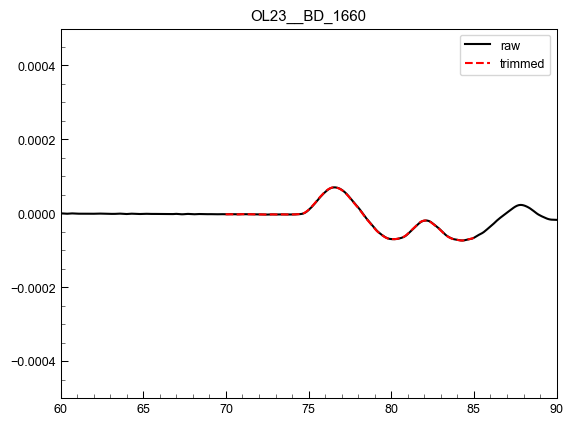

In [39]:
# Check the trimming
plt.plot(tr_obs.times()*1e6, tr_obs.data/amp_correction[-1], "k-", label="raw")
plt.plot((pt.microseconds+(p_theoretical-pwin_len_pre)*1e3) + tr_obs_trim.times()*1e6, tr_obs_trim.data, "r--", label="trimmed")
plt.xlim([60, 90])
plt.ylim([-5e-4, 5e-4])
plt.legend(loc=0)
plt.title(f"{tr_obs.stats.dataindex}")

In [40]:
## Preprocessing
tr_obs_trim.detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
tr_syn_trim.detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
tr_obs_noise.detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")

BIAX.OL23.1660.OY | 1970-01-01T00:00:00.00005800Z - 1970-01-01T00:00:00.00007300Z | 10000000.0 Hz, 151 samples

In [41]:
# Compute maximum cross-correlation function
taper_percent = 0.5
max_lag_shift = 30

cc = correlate(tr_obs_trim.taper(max_percentage = taper_percent, type='hann'), tr_syn_trim.taper(max_percentage = taper_percent, type='hann'), max_lag_shift, demean=True, normalize='naive') # the order is 1. obs and 2. syn
N_shift, _ = xcorr_max(cc,  abs_max=False)
N_shift

5

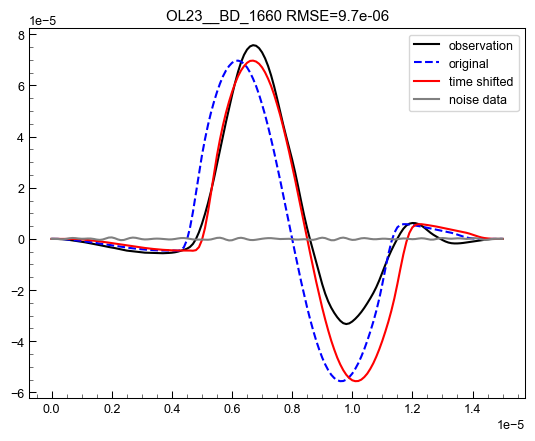

In [42]:
# Check if the max cc time shift works
plt.plot(tr_obs_trim.times(), tr_obs_trim.data, "k-", label="observation")
plt.plot(tr_obs_trim.times(), tr_syn_trim.data, "b--", label="original")
plt.plot(tr_obs_trim.times(), np.roll(tr_syn_trim.data, N_shift), "r-", label="time shifted")
plt.plot(tr_obs_noise.times(), tr_obs_noise.data, "-", c="gray", label="noise data")
# Compute RMSE
RMSE = np.sqrt(np.mean(np.square(tr_obs_trim.data - np.roll(tr_syn_trim.data, N_shift))))
plt.title(f"{tr_obs_trim.stats.dataindex} RMSE={RMSE:.2g}")
plt.legend(loc=1)

## Apply smoothing on the spectra

We follow Clarke et al. (2011) to apply the smoothing on the spectra. The function is implemented in MSNoise (https://github.com/ROBelgium/MSNoise/blob/5b12a782b67e9138898259f1729e1d805a6d7eb0/msnoise/s05compute_mwcs2.py#L252C20-L266C69).

We convolve the hanning window on the spectra.

In [43]:
NFFT = 2**8
print(len(tr_obs_trim.times()), len(tr_obs_noise.times()), NFFT)
smoothing_half_win = 3
hanningwindow = signal.windows.hann(2*smoothing_half_win+1).astype('complex')
hanningwindow /= smoothing_half_win #len(hanningwindow) # divide by half win so that the summation of window weights is unity
print(np.sum(hanningwindow))

# smoothing half width in frequency

# Compute frequency vector for FFT
Y_obs_freq = np.fft.rfftfreq(NFFT, d=tr_obs_trim.stats.delta)

dfreq= Y_obs_freq[1] - Y_obs_freq[0]
smooth_half_win_freq = smoothing_half_win * dfreq

print(f"smoothing half win:{smooth_half_win_freq/1e3}kHz")

151 151 256
(1+0j)
smoothing half win:117.1875kHz


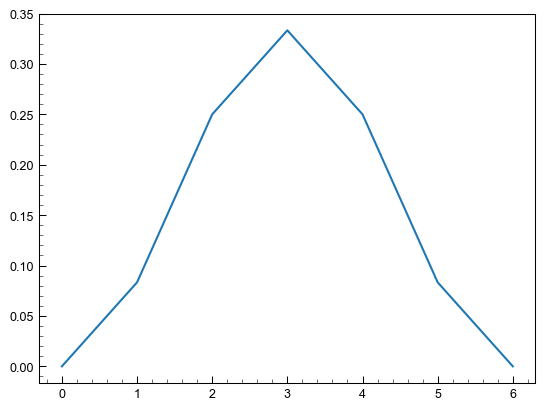

In [44]:
plt.plot(hanningwindow.real)

## Process all the pairs

In [45]:
figdir_Bomega = "../figure/p08_Bomega/"
if not os.path.exists(figdir_Bomega):
    os.makedirs(figdir_Bomega)

In [46]:
2**8

256

In [47]:
ampfactor_comparison = np.zeros((0, 4))
trcount = 0
theta_evalerr = np.zeros(Nd)
err_evalerr = np.zeros(Nd)

pwin_len_margin = 3e-6 # to avoid the discontinuity due to the roll time shift

# NFFT = 2**8 # defined above
noise_Pbackward = 5e-6
noise_winlen = 15e-6 # [s]
# smoothing_half_win = 3  # defined above

Bomega_all = dict()
taper_percent = 0.5 #0.1
max_lag_shift = 30

# centralize the STF to avoid asymmetric taper
centralize_loc = (pwin_len*1e-3) / 2 + pwin_len_margin

hanningwindow = signal.windows.hann(2*smoothing_half_win+1).astype('complex')
hanningwindow /= smoothing_half_win #len(hanningwindow) # divide by half win so that the summation of window weights is unity
print(np.sum(hanningwindow))

# smoothing half width in frequency

dfreq= Y_obs_freq[1] - Y_obs_freq[0]
smooth_half_win_freq = smoothing_half_win * dfreq
print(f"smoothing half win:{smooth_half_win_freq/1e3}kHz")

for stnm in tqdm(AEsensors):
# for stnm in tqdm(AEsensors[19:20]):
    # stnm = AEsensors[11]
    finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform_longpretrig.pickle".format(stnm)) 
    st = read(finame, format="PICKLE")

    # prefilitering traces
    # demean
#     st.detrend(type='demean')
#     # apply bandpass
#     st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)     # NO FILTER for the analysis of attenuation
    # apply taper
#     st.taper(max_percentage=0.001)   

    # Select observation and synthetic
    st_obs = st.select(channel='OY')
    st_syn = st.select(channel='SY')
    
    # Extract the traces used in the Si inversion
    for i, tr_obs in enumerate(st_obs):
        if tr_obs.stats.dataindex not in np.squeeze(df_caseid.values):
            print(tr_obs.stats.dataindex)
            st_obs.remove(tr_obs)
    
    for i, tr_obs in enumerate(st_obs):

            dataindex = tr_obs.stats.dataindex
            tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            tvec = np.array(range(0, tr_syn.stats.npts))*tr_syn.stats.delta*1e3 - tr_obs.stats.pretrigger #[ms]

            #---compute correction coefficient from Si, Tj and alpha(theta)---#
            amp_correction = np.zeros(4) # 4 models
            ii, jj = [cij[dataindex][0]-1, cij[dataindex][1]-1]
            kk = df_caseid.index[df_caseid.caseid == dataindex][0]

            Asyn = Aksyn[kk]

            # model 1: gain model
            Si1 = df_Si["model1"][ii]
            amp_correction[0] = Si1

            # model 3: directionality-dominant
            Si3 = df_Si["model3"][ii]
            theta3 = df_disttheta["theta"][kk]
#             alpha3 = model_bell(theta3, 1.0, a3, b3) # bell-shape 
#             amp_correction[1] = Si3*alpha3
            TR3 = df_TR["model3"][0]
            k3 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta3), TR3, R)
            amp_correction[1] = Si3*k3
            #model 2: source impact-dominant
            Si2 = df_Si["model2"][ii]
            Tj2 = df_Tj["model2"][jj]
            amp_correction[2] = Si2*Tj2
            
            # model 4: mix model
            Si4 = df_Si["model4"][ii]
            Tj4 = df_Tj["model4"][jj]
            theta4 = df_disttheta["theta"][kk]
#             alpha4 = model_bell(theta4, 1.0, a4, b4) # bell-shape 
            TR4 = df_TR["model4"][0]
            k4 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta4), TR4, R)

            amp_correction[3] = Si4*Tj4*k4

#             print((Si4, Tj4, k4))
            ampfactor_comparison = np.vstack((ampfactor_comparison, [df_disttheta["theta"][kk], 
                            amp_correction[3]/amp_correction[0],  amp_correction[3]/amp_correction[1], amp_correction[3]/amp_correction[2]]))
    
            #---------------------------------------------------------------------------------#
#             print(dataindex+":"+str(amp_correction))
#             # plot synthetic waveform
#             p0 = axs[i, 0].plot(tvec, 1e3*tr_syn.data, 'r-', label='syn', zorder=2)
#             axs[i, 1].plot(tvec, 1e3*tr_syn.data, 'r-', label='syn', zorder=2)

#             axs[i, 0].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1.5, label=xcase[-1]) # use the best model with model 4
#             axs[i, 1].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1.5, label=xcase[-1])

            #---------------------------------------------------------------------------------#
            #===Compute B(omega)===#
            #---------------------------------------------------------------------------------#

            st0 = tr_obs.stats.starttime
            pt = timedelta(milliseconds = tr_obs.stats.pretrigger)

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            # trim Pwave
            starttime = st0+pt+(p_theoretical-pwin_len_pre)*1e-3 - pwin_len_margin
            endtime = st0+pt+(p_theoretical-pwin_len_pre+pwin_len)*1e-3 + pwin_len_margin

            tr_obs_trim = tr_obs.copy() # avoid error in multiple trim
            tr_obs_trim.trim(starttime, endtime, pad=True, fill_value=0.0)
            tr_obs_trim.data /= amp_correction[-1]

            # trim synthetic data
            tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
            tr_syn_trim.trim(starttime, endtime, pad=True, fill_value=0.0)

            # trim the observation noise

            print(f"noise margin: {((tr_obs.stats.pretrigger+p_theoretical)*1e-3-noise_Pbackward)*1e6}μs")
            if ((tr_obs.stats.pretrigger+p_theoretical)*1e-3-noise_Pbackward)*1e6 < noise_winlen:
                print("P_theoretical is smaller than noise winlen")

            tr_obs_noise = tr_obs.copy() # avoid error in multiple trim

            noise_end_time = st0+pt+p_theoretical*1e-3-noise_Pbackward
            noise_start_time = noise_end_time - noise_winlen # synchronize the window length with the P wave pulse

            tr_obs_noise.trim(noise_start_time, noise_end_time, pad=True, fill_value=0.0) # trim before the p wave window
            tr_obs_noise.data /= amp_correction[-1]

            # preprocessing the traces
#             tr_obs_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
#             tr_syn_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
#             tr_obs_noise.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
            
#             tr_obs_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
#             tr_syn_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
#             tr_obs_noise.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
            
            # detrend by the first 5 microsec
            noise_npts = int(5e-6*tr_obs_trim.stats.sampling_rate)
            for tr in [tr_obs_trim, tr_syn_trim, ]:
                kp = np.polyfit(tr.times()[:noise_npts], tr.data[:noise_npts], 1)
                tr.data -= np.polyval(kp, tr.times())
#                 tr.taper(max_percentage = taper_percent, type='hann') # apply taper after time shifted
            
            # for noise, detrend by the entire signal
            for tr in [tr_obs_noise]:
                kp = np.polyfit(tr.times()[:], tr.data[:], 1)
                tr.data -= np.polyval(kp, tr.times())
                tr.taper(max_percentage = taper_percent, type='hann')
                      
            #---Update: compute RMSE at max cc--#
            # 1. shift the trace at maximum correlation function
            cc = correlate(tr_obs_trim.copy().taper(max_percentage = taper_percent).data, tr_syn_trim.copy().taper(max_percentage = taper_percent).data, max_lag_shift, demean=False, normalize='naive') # the order is 1. obs and 2. syn
            N_shift, _ = xcorr_max(cc,  abs_max=False)
            #-----------------------------------#
            tr_syn_trim_shifted = tr_syn_trim.copy()
            tr_syn_trim_shifted.data = np.roll(tr_syn_trim.data, N_shift)# assuming the time shift is not large
            
            # time shift to centralize the trace
#             t_syn_center = (tr_syn_trim_shifted.times()[np.argmin(tr_syn_trim_shifted.data)] + tr_syn_trim_shifted.times()[np.argmax(tr_syn_trim_shifted.data)])/2
            t_syn_center = (tr_syn_trim_shifted.times()[np.argmax(tr_syn_trim_shifted.data)])
            Ncentralize = int((t_syn_center - centralize_loc)/tr_syn_trim_shifted.stats.delta) # The P-wave pulse was centered within a symmetric time window for analysis.
            for tr in [tr_obs_trim, tr_syn_trim_shifted, tr_syn_trim]:
                tr.data = np.roll(tr.data, -Ncentralize)
                
            # trim the margin
            st0_margin = tr_obs_trim.stats.starttime
            starttime_margin = st0_margin + pwin_len_margin
            endtime_margin = st0_margin + pwin_len_margin + pwin_len*1e-3

            for tr in [tr_obs_trim, tr_syn_trim_shifted, tr_syn_trim]:
                tr.trim(starttime_margin, endtime_margin)
                # print(f"data length:{tr.stats.dataindex} {tr.stats.npts}")
            
            # apply tapering
            tr_obs_trim_raw = tr_obs_trim.copy()
            for tr in [tr_obs_trim, tr_syn_trim, tr_syn_trim_shifted, tr_syn_trim]:
                tr.taper(max_percentage = taper_percent, type='hann')
            
            # compute RMSE
            RMSE = np.sqrt(np.mean(np.square(tr_obs_trim.data - np.roll(tr_syn_trim_shifted.data, N_shift))))
            # compute VR
            VRtmp1 = np.linalg.norm(tr_obs_trim.data - tr_syn_trim_shifted.data, axis=0, ord=2) ** 2 
            VRtmp2 = np.linalg.norm(tr_obs_trim.data, axis=0, ord=2)**2 # scalled by the observation
            VR = 1.0 - VRtmp1/VRtmp2
            
            # Compute FFT
            Y_obs = np.fft.rfft(tr_obs_trim.data, n=NFFT)
            Y_syn = np.fft.rfft(tr_syn_trim_shifted.data, n=NFFT)
            Y_obs_noise = np.fft.rfft(tr_obs_noise.data, n=NFFT)

            Y_obs_freq = np.fft.rfftfreq(NFFT, d=tr_obs_trim.stats.delta)
            Y_syn_freq = np.fft.rfftfreq(NFFT, d=tr_syn_trim_shifted.stats.delta)
            Y_obs_noise_freq = np.fft.rfftfreq(NFFT, d=tr_obs_noise.stats.delta)

            # Apply smoothing
            # ref: https://github.com/ROBelgium/MSNoise/blob/master/msnoise/s05compute_mwcs2.py#L92
            Y_obs_smoothed = signal.convolve(Y_obs, hanningwindow.real, "same")
            Y_syn_smoothed = signal.convolve(Y_syn, hanningwindow.real, "same")
            Y_obs_noise_smoothed = signal.convolve(Y_obs_noise, hanningwindow.real, "same")


            # compute B(omega)
            B_attenu = Y_obs/Y_syn
            Battenu_smoothed = Y_obs_smoothed/Y_syn_smoothed

#             # Compute maximum cross-correlation function
#             signal.correlate(tr_obs_trim.data, tr_syn_trim.data)
            
            # plot figure for debugging
            fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(7.5, 3.58)) #figsize=(9, 4))
            
            # plot P waveform
            ax1.plot(tr_obs_trim.times()*1e6, tr_obs_trim.data*1e3, "k-", label="observation")
            ax1.plot(tr_obs_trim.times()*1e6, tr_obs_trim_raw.data*1e3, "k:", label="observation no taper")
            ax1.plot(tr_syn_trim.times()*1e6, tr_syn_trim.data*1e3, "r:", label="synthetic")
#             ax1.plot(tr_syn_trim.times()*1e6 + N_shift*tr_syn_trim.stats.delta*1e6, tr_syn_trim.data*1e3, "r--", label="synthetic max. cc")
            ax1.plot(tr_syn_trim_shifted.times()*1e6, tr_syn_trim_shifted.data*1e3, "r-", label="synthetic shifted")
            ax1.plot(tr_obs_noise.times()*1e6, tr_obs_noise.data*1e3, "--", c="gray", label="noise")
            ax1.set_xlabel("Time [μs]")
            ax1.set_ylabel("Velocity [mm/s]")
            ax1.set_title(tr_obs_trim.stats.dataindex)
            ax1.set_xlim([0.0, 15])

            ylimit_wf_p = np.array([-Asyn, Asyn])*3e3

            ax1.set_ylim(ylimit_wf_p)
#             ax1.set_ylim([-0.05, 0.05])
            
            
            ax1.text(0.36, 0.05, f"RMSE={RMSE*1e3:.3f}mm/s, VR={VR:.3f}\nNshift={N_shift}, Ncenter={Ncentralize}", transform = ax1.transAxes)
            
            # plot P wave spectra
            amp0 = np.max(np.abs(Y_obs)) # normalize the dB by the maximum of observation
            ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Y_obs)/amp0), "b.--", label="observation")
            ax2.semilogx(Y_syn_freq/1e6,  20 * np.log10(np.abs(Y_syn)/amp0), "r.--", label="synthetic")
            ax2.semilogx(Y_obs_noise_freq/1e6,  20 * np.log10(np.abs(Y_obs_noise)/amp0),  "k.--", label="observation noise")
            ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(B_attenu)), "g.--", label="B(ω)")

            
            amp0_smoothed = np.max(np.abs(Y_obs_smoothed))
            ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Y_obs_smoothed)/amp0_smoothed), "b.-", label="")
            ax2.semilogx(Y_syn_freq/1e6,  20 * np.log10(np.abs(Y_syn_smoothed)/amp0_smoothed), "r.-", label="")
            ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Battenu_smoothed)), "g.-", label="")
            ax2.semilogx(Y_obs_noise_freq/1e6,  20 * np.log10(np.abs(Y_obs_noise_smoothed)/amp0_smoothed),  "k.-", label="")
            
            ax2.set_xlabel("Frequency [MHz]")
            ax2.set_ylabel("Amplitude [dB]")

            ax2.set_xlim([0.02, 2])
            ax2.set_ylim([-100, 20])
            ax2.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)
            ax2.legend(loc=3, fontsize=9, ncol=2)
            ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

            plt.tight_layout()
#             plt.savefig("../figure/velocityspectra.png", dpi=300)
#             plt.savefig("../figure/velocityspectra.eps")

            plt.savefig(figdir_Bomega+"/computeBomega_{}.png".format(dataindex), format="png", dpi=70, bbox_inches="tight")
    
            # dump the data
        
            Bomega_all[f"{dataindex}_dist"] = tr_obs.stats.dist
            Bomega_all[f"{dataindex}_VR"] = VR
            Bomega_all[f"{dataindex}_RMSE"] = RMSE
            Bomega_all[f"{dataindex}_Y_obs"] = Y_obs
            Bomega_all[f"{dataindex}_Y_syn"] = Y_syn
            Bomega_all[f"{dataindex}_Y_obs_noise"] = Y_obs_noise

            Bomega_all[f"{dataindex}_Battenu"] = B_attenu
            Bomega_all[f"{dataindex}_Battenu_smoothed"] = Battenu_smoothed
             
            plt.clf()
            plt.close()
        
        
Bomega_all["NFFT"] = NFFT
Bomega_all["dt"] = tr_obs_trim.stats.delta
Bomega_all["noise_Pbackward"] = noise_Pbackward
Bomega_all["noise_winlen"] = NFFT
Bomega_all["smoothing_half_win"] = smoothing_half_win
Bomega_all["smooth_half_win_freq"] = smooth_half_win_freq
Bomega_all["taper_percent"] = taper_percent


(1+0j)
smoothing half win:117.1875kHz


  0%|                                                    | 0/32 [00:00<?, ?it/s]

OL01__BD_0460
OL01__BD_0580
noise margin: 59.99630502376315μs
noise margin: 72.98638089529896μs


  3%|█▍                                          | 1/32 [00:00<00:16,  1.93it/s]

OL02__BD_0700
noise margin: 79.32302024942828μs
noise margin: 62.58638089529897μs
noise margin: 61.10810544544971μs
noise margin: 75.26185997775802μs


  6%|██▊                                         | 2/32 [00:01<00:25,  1.19it/s]

OL03__BD_0340
OL03__BD_0940
noise margin: 77.42898268206953μs
noise margin: 61.86185997775803μs
noise margin: 61.823890504497555μs
noise margin: 76.68544110008874μs


  9%|████▏                                       | 3/32 [00:02<00:26,  1.09it/s]

OL04__BD_0580
OL04__BD_1180
noise margin: 81.90130831923413μs
noise margin: 65.78544110008873μs
noise margin: 60.15098390790163μs
noise margin: 72.60561359167103μs


 12%|█████▌                                      | 4/32 [00:03<00:27,  1.04it/s]

OL05__BD_0820
OL05__BD_0940
OL05__BD_1420
OL05__BD_1540
noise margin: 66.70561359167104μs
noise margin: 59.32747859147145μs
noise margin: 71.68774822823397μs


 16%|██████▉                                     | 5/32 [00:04<00:24,  1.12it/s]

OL06__BD_1060
OL06__BD_1660
noise margin: 79.53308296313271μs
noise margin: 62.687748228233986μs
noise margin: 61.55865376599228μs
noise margin: 76.10050424296259μs


 19%|████████▎                                   | 6/32 [00:05<00:24,  1.07it/s]

OL07__BD_1300
OL07__BD_1420
OL07__BD_1900
OL07__BD_2020
noise margin: 68.80050424296259μs
noise margin: 59.17995438384326μs
noise margin: 68.56088272258206μs


 22%|█████████▋                                  | 7/32 [00:06<00:22,  1.11it/s]

OL08__BD_1540
OL08__BD_1660
OL08__BD_2140
OL08__BD_2260
noise margin: 70.36088272258206μs
noise margin: 59.39765980946528μs
noise margin: 67.74806353277808μs


 25%|███████████                                 | 8/32 [00:07<00:21,  1.14it/s]

OL09__BD_1780
OL09__BD_1900
OL09__BD_2500
noise margin: 71.34806353277807μs
noise margin: 60.06486854309506μs
noise margin: 66.47051401265357μs
noise margin: 82.122361442164μs


 28%|████████████▍                               | 9/32 [00:08<00:21,  1.07it/s]

OL10__BD_2020
OL10__BD_2140
OL10__BD_2620
OL10__BD_2740
noise margin: 72.97051401265357μs
noise margin: 60.179617698531914μs
noise margin: 65.45690948096933μs


 31%|█████████████▍                             | 10/32 [00:08<00:19,  1.12it/s]

OL11__BD_2380
OL11__BD_2980
noise margin: 72.45690948096932μs
noise margin: 60.1831582402777μs
noise margin: 65.5017136344947μs
noise margin: 81.82403244138997μs


 34%|██████████████▊                            | 11/32 [00:09<00:19,  1.06it/s]

OL12__BD_2620
OL12__BD_3220
noise margin: 75.70171363449471μs
noise margin: 60.88956941962455μs
noise margin: 62.90378053519929μs
noise margin: 77.94668224522376μs


 38%|████████████████▏                          | 12/32 [00:11<00:19,  1.03it/s]

OL13__BD_2860
OL13__BD_3460
noise margin: 77.10378053519929μs
noise margin: 61.938427712302804μs
noise margin: 62.35209128140381μs
noise margin: 77.15928057547474μs


 41%|█████████████████▍                         | 13/32 [00:12<00:19,  1.01s/it]

OL14__BD_3100
OL14__BD_3700
noise margin: 79.09297442739447μs
noise margin: 62.559280575474745μs
noise margin: 60.84800733330167μs
noise margin: 75.78110836803808μs


 44%|██████████████████▊                        | 14/32 [00:13<00:18,  1.01s/it]

OL15__BD_3340
OL15__BD_3940
noise margin: 79.89429556020704μs
noise margin: 63.98110836803809μs
noise margin: 60.31513145651034μs
noise margin: 74.03121930324279μs


 47%|████████████████████▏                      | 15/32 [00:14<00:17,  1.03s/it]

OL16__BD_3580
noise margin: 81.68246908240056μs
noise margin: 64.7312193032428μs
noise margin: 59.90665359225387μs


 50%|█████████████████████▌                     | 16/32 [00:14<00:15,  1.05it/s]

OL17__BD_0580
noise margin: 62.396305023763155μs
noise margin: 61.28638089529898μs
noise margin: 75.90810544544972μs


 53%|██████████████████████▊                    | 17/32 [00:15<00:13,  1.13it/s]

OL18__BD_0220
OL18__BD_0820
noise margin: 79.56169738480196μs
noise margin: 64.00810544544971μs
noise margin: 60.861859977758044μs
noise margin: 74.62389050449754μs


 56%|████████████████████████▏                  | 18/32 [00:16<00:13,  1.04it/s]

OL19__BD_0460
OL19__BD_1060
OL19__BD_1180
noise margin: 81.30465666734244μs
noise margin: 64.82389050449754μs
noise margin: 59.68544110008873μs
noise margin: 72.75098390790163μs


 59%|█████████████████████████▌                 | 19/32 [00:17<00:13,  1.01s/it]

OL20__BD_0700
OL20__BD_1300
OL20__BD_1420
noise margin: 82.69952124610104μs
noise margin: 66.05098390790162μs
noise margin: 59.20561359167103μs
noise margin: 71.32747859147145μs


 62%|██████████████████████████▉                | 20/32 [00:19<00:12,  1.02s/it]

OL21__BD_0940
OL21__BD_1540
OL21__BD_1660
noise margin: 84.08853580826114μs
noise margin: 67.22747859147144μs
noise margin: 59.087748228233984μs
noise margin: 69.95865376599228μs


 66%|████████████████████████████▏              | 21/32 [00:20<00:11,  1.02s/it]

OL22__BD_1180
OL22__BD_1780
OL22__BD_1900
noise margin: 85.21145978995449μs
noise margin: 68.65865376599227μs
noise margin: 58.600504242962586μs
noise margin: 69.17995438384325μs


 69%|█████████████████████████████▌             | 22/32 [00:21<00:10,  1.03s/it]

OL23__BD_1420
OL23__BD_2020
OL23__BD_2140
noise margin: 86.48580239320574μs
noise margin: 69.97995438384325μs
noise margin: 59.36088272258207μs
noise margin: 68.09765980946528μs


 72%|██████████████████████████████▉            | 23/32 [00:22<00:09,  1.06s/it]

OL24__BD_1660
OL24__BD_1780
OL24__BD_2380
noise margin: 70.79765980946527μs
noise margin: 59.34806353277808μs
noise margin: 66.06486854309507μs
noise margin: 83.51766895932765μs


 75%|████████████████████████████████▎          | 24/32 [00:23<00:08,  1.05s/it]

OL25__BD_1900
OL25__BD_2020
OL25__BD_2620
noise margin: 72.36486854309504μs
noise margin: 59.87051401265357μs
noise margin: 64.6796176985319μs
noise margin: 82.42109284061671μs


 78%|█████████████████████████████████▌         | 25/32 [00:24<00:07,  1.05s/it]

OL26__BD_2260
OL26__BD_2860
noise margin: 74.47961769853191μs
noise margin: 60.556909480969345μs
noise margin: 64.18315824027769μs
noise margin: 80.75192011463798μs


 81%|██████████████████████████████████▉        | 26/32 [00:25<00:06,  1.05s/it]

OL27__BD_2500
OL27__BD_3100
noise margin: 74.8831582402777μs
noise margin: 60.601713634494715μs
noise margin: 63.089569419624546μs
noise margin: 79.41423005050065μs


 84%|████████████████████████████████████▎      | 27/32 [00:26<00:05,  1.07s/it]

OL28__BD_2740
OL28__BD_3340
noise margin: 76.38956941962455μs
noise margin: 61.603780535199284μs
noise margin: 61.438427712302804μs
noise margin: 77.46105486959131μs


 88%|█████████████████████████████████████▋     | 28/32 [00:27<00:04,  1.07s/it]

OL29__BD_2980
OL29__BD_3580
noise margin: 78.60146235854438μs
noise margin: 62.65209128140382μs
noise margin: 61.85928057547475μs
noise margin: 76.74800733330169μs


 91%|██████████████████████████████████████▉    | 29/32 [00:28<00:03,  1.06s/it]

OL30__BD_3220
OL30__BD_3820
noise margin: 79.38624945999604μs
noise margin: 63.34800733330168μs
noise margin: 60.181108368038096μs
noise margin: 74.71513145651035μs


 94%|████████████████████████████████████████▎  | 30/32 [00:29<00:02,  1.05s/it]

OL31__BD_3460
noise margin: 80.93554178486096μs
noise margin: 65.11513145651033μs
noise margin: 60.831219303242804μs
noise margin: 74.20665359225387μs


 97%|█████████████████████████████████████████▋ | 31/32 [00:30<00:01,  1.06s/it]

OL32__BD_3700
OL32__BD_3820
noise margin: 65.50665359225387μs


100%|███████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]


In [48]:
with open('../data/Bomega_all.pickle', mode='wb') as fo:
    pickle.dump(Bomega_all, fo)

In [49]:
pwin_len

0.015

# Plot figure on the representative source-station pair and attenuation

In [50]:
selected_BDid = '0820' # balldrop id for master plot

(1+0j)
smoothing half win:117.1875kHz


  0%|                                                     | 0/1 [00:00<?, ?it/s]

OL20__BD_0700
OL20__BD_1300
OL20__BD_1420
[0. 0. 0. 0.]
noise margin: 82.69952124610104μs
Ncentralize for OL20__BD_0820: -13
data length:OL20__BD_0820 151
data length:OL20__BD_0820 151
data length:OL20__BD_0820 151
freq normalized at 100000.0Hz


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


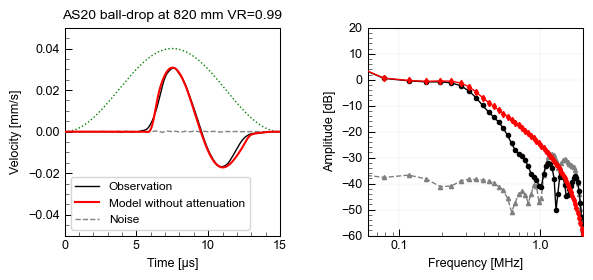

In [51]:
ampfactor_comparison = np.zeros((0, 4))
trcount = 0
theta_evalerr = np.zeros(Nd)
err_evalerr = np.zeros(Nd)

pwin_len_margin = 3e-6 # to avoid the discontinuity due to the roll time shift

NFFT = 2**8
noise_Pbackward = 5e-6
noise_winlen = 15e-6 # [s]
smoothing_half_win = 3

Bomega_all = dict()
taper_percent = 0.5 #0.1
max_lag_shift = 30

# centralize the STF to avoid asymmetric taper
centralize_loc = (pwin_len*1e-3) / 2 + pwin_len_margin

hanningwindow = signal.windows.hann(2*smoothing_half_win+1).astype('complex')
hanningwindow /= smoothing_half_win #len(hanningwindow) # divide by half win so that the summation of window weights is unity
print(np.sum(hanningwindow))

# smoothing half width in frequency

dfreq= Y_obs_freq[1] - Y_obs_freq[0]
smooth_half_win_freq = smoothing_half_win * dfreq
print(f"smoothing half win:{smooth_half_win_freq/1e3}kHz")

# for stnm in tqdm(AEsensors):
for stnm in tqdm(AEsensors[19:20]):
    # stnm = AEsensors[11]
    finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform_longpretrig.pickle".format(stnm)) 
    st = read(finame, format="PICKLE")

    # prefilitering traces
    # demean
#     st.detrend(type='demean')
#     # apply bandpass
#     st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)     # NO FILTER for the analysis of attenuation
    # apply taper
#     st.taper(max_percentage=0.001)   

    # Select observation and synthetic
    st_obs = st.select(channel='OY')
    st_syn = st.select(channel='SY')
    
    # Extract the traces used in the Si inversion
    for i, tr_obs in enumerate(st_obs):
        if tr_obs.stats.dataindex not in np.squeeze(df_caseid.values):
            print(tr_obs.stats.dataindex)
            st_obs.remove(tr_obs)
    
    for i, tr_obs in enumerate(st_obs):
        
            if tr_obs.stats.location != selected_BDid:
                continue
                    
            dataindex = tr_obs.stats.dataindex
            tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            tvec = np.array(range(0, tr_syn.stats.npts))*tr_syn.stats.delta*1e3 - tr_obs.stats.pretrigger #[ms]

            #---compute correction coefficient from Si, Tj and alpha(theta)---#
            amp_correction = np.zeros(4) # 4 models
            print(amp_correction)
            ii, jj = [cij[dataindex][0]-1, cij[dataindex][1]-1]
            kk = df_caseid.index[df_caseid.caseid == dataindex][0]

            Asyn = Aksyn[kk]

            # model 1: gain model
            Si1 = df_Si["model1"][ii]
            amp_correction[0] = Si1

            # model 3: directionality-dominant
            Si3 = df_Si["model3"][ii]
            theta3 = df_disttheta["theta"][kk]
#             alpha3 = model_bell(theta3, 1.0, a3, b3) # bell-shape 
#             amp_correction[1] = Si3*alpha3
            TR3 = df_TR["model3"][0]
            k3 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta3), TR3, R)
            amp_correction[1] = Si3*k3
            #model 2: source impact-dominant
            Si2 = df_Si["model2"][ii]
            Tj2 = df_Tj["model2"][jj]
            amp_correction[2] = Si2*Tj2
            
            # model 4: mix model
            Si4 = df_Si["model4"][ii]
            Tj4 = df_Tj["model4"][jj]
            theta4 = df_disttheta["theta"][kk]
#             alpha4 = model_bell(theta4, 1.0, a4, b4) # bell-shape 
            TR4 = df_TR["model4"][0]
            k4 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta4), TR4, R)

            amp_correction[3] = Si4*Tj4*k4

#             print((Si4, Tj4, k4))
            ampfactor_comparison = np.vstack((ampfactor_comparison, [df_disttheta["theta"][kk], 
                            amp_correction[3]/amp_correction[0],  amp_correction[3]/amp_correction[1], amp_correction[3]/amp_correction[2]]))
    
            #---------------------------------------------------------------------------------#
#             print(dataindex+":"+str(amp_correction))
#             # plot synthetic waveform
#             p0 = axs[i, 0].plot(tvec, 1e3*tr_syn.data, 'r-', label='syn', zorder=2)
#             axs[i, 1].plot(tvec, 1e3*tr_syn.data, 'r-', label='syn', zorder=2)

#             axs[i, 0].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1.5, label=xcase[-1]) # use the best model with model 4
#             axs[i, 1].plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", lw=1.5, label=xcase[-1])

            #---------------------------------------------------------------------------------#
            #===Compute B(omega)===#
            #---------------------------------------------------------------------------------#

            st0 = tr_obs.stats.starttime
            pt = timedelta(milliseconds = tr_obs.stats.pretrigger)

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            # trim Pwave
            starttime = st0+pt+(p_theoretical-pwin_len_pre)*1e-3 - pwin_len_margin
            endtime = st0+pt+(p_theoretical-pwin_len_pre+pwin_len)*1e-3 + pwin_len_margin

            tr_obs_trim = tr_obs.copy() # avoid error in multiple trim
            tr_obs_trim.trim(starttime, endtime, pad=True, fill_value=0.0)
            tr_obs_trim.data /= amp_correction[-1]

            # trim synthetic data
            tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
            tr_syn_trim.trim(starttime, endtime, pad=True, fill_value=0.0)

            # trim the observation noise

            print(f"noise margin: {((tr_obs.stats.pretrigger+p_theoretical)*1e-3-noise_Pbackward)*1e6}μs")
            if ((tr_obs.stats.pretrigger+p_theoretical)*1e-3-noise_Pbackward)*1e6 < noise_winlen:
                print("P_theoretical is smaller than noise winlen")

            tr_obs_noise = tr_obs.copy() # avoid error in multiple trim

            noise_end_time = st0+pt+p_theoretical*1e-3-noise_Pbackward
            noise_start_time = noise_end_time - noise_winlen

            tr_obs_noise.trim(noise_start_time, noise_end_time, pad=True, fill_value=0.0) # trim before the p wave window
            tr_obs_noise.data /= amp_correction[-1]

            # preprocessing the traces
#             tr_obs_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
#             tr_syn_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
#             tr_obs_noise.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean")
            
#             tr_obs_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
#             tr_syn_trim.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
#             tr_obs_noise.detrend(type="demean").detrend(type="linear").taper(max_percentage = 0.05).detrend(type="demean").detrend(type="linear")
            
            # remove offset and detrend by the first 5 microsec
            noise_npts = int(5e-6*tr_obs_trim.stats.sampling_rate)
            for tr in [tr_obs_trim, tr_syn_trim, ]:
                kp = np.polyfit(tr.times()[:noise_npts], tr.data[:noise_npts], 1)
                tr.data -= np.polyval(kp, tr.times())
#                 tr.taper(max_percentage = taper_percent, type='hann') # apply taper after time shifted
            
            # for noise, detrend by the entire signal
            for tr in [tr_obs_noise]:
                kp = np.polyfit(tr.times()[:], tr.data[:], 1)
                tr.data -= np.polyval(kp, tr.times())
                tr.taper(max_percentage = taper_percent, type='hann')
                      
            #---Update: compute RMSE at max cc--#
            # 1. shift the trace at maximum correlation function
            cc = correlate(tr_obs_trim.copy().taper(max_percentage = taper_percent).data, tr_syn_trim.copy().taper(max_percentage = taper_percent).data, max_lag_shift, demean=False, normalize='naive') # the order is 1. obs and 2. syn
            N_shift, _ = xcorr_max(cc,  abs_max=False)
            #-----------------------------------#
            tr_syn_trim_shifted = tr_syn_trim.copy()
            tr_syn_trim_shifted.data = np.roll(tr_syn_trim.data, N_shift)# the discontinuity is trimmed by the margin
            
            # time shift to centralize the trace
#             t_syn_center = (tr_syn_trim_shifted.times()[np.argmin(tr_syn_trim_shifted.data)] + tr_syn_trim_shifted.times()[np.argmax(tr_syn_trim_shifted.data)])/2
            t_syn_center = (tr_syn_trim_shifted.times()[np.argmax(tr_syn_trim_shifted.data)])
            Ncentralize = int((t_syn_center - centralize_loc)/tr_syn_trim_shifted.stats.delta)
            for tr in [tr_obs_trim, tr_syn_trim_shifted, ]:
                tr.data = np.roll(tr.data, -Ncentralize)
            
            print(f"Ncentralize for {tr_obs_trim.stats.dataindex}: {Ncentralize}")
            
            # trim the margin
            st0_margin = tr_obs_trim.stats.starttime
            starttime_margin = st0_margin + pwin_len_margin
            endtime_margin = st0_margin + pwin_len_margin + pwin_len*1e-3

            for tr in [tr_obs_trim, tr_syn_trim_shifted, tr_syn_trim]:
                tr.trim(starttime_margin, endtime_margin)
                print(f"data length:{tr.stats.dataindex} {tr.stats.npts}")
            
            # apply tapering
            for tr in [tr_obs_trim, tr_syn_trim_shifted, tr_syn_trim]:
                tr.taper(max_percentage = taper_percent, type='hann')
            
            # compute RMSE
            RMSE = np.sqrt(np.mean(np.square(tr_obs_trim.data - np.roll(tr_syn_trim_shifted.data, N_shift))))
            # compute VR
            VRtmp1 = np.linalg.norm(tr_obs_trim.data - tr_syn_trim_shifted.data, axis=0, ord=2) ** 2 
            VRtmp2 = np.linalg.norm(tr_obs_trim.data, axis=0, ord=2)**2 # scalled by the observation
            VR = 1.0 - VRtmp1/VRtmp2
            
            # Compute FFT
            Y_obs = np.fft.rfft(tr_obs_trim.data, n=NFFT)
            Y_syn = np.fft.rfft(tr_syn_trim_shifted.data, n=NFFT)
            Y_obs_noise = np.fft.rfft(tr_obs_noise.data, n=NFFT)

            Y_obs_freq = np.fft.rfftfreq(NFFT, d=tr_obs_trim.stats.delta)
            Y_syn_freq = np.fft.rfftfreq(NFFT, d=tr_syn_trim_shifted.stats.delta)
            Y_obs_noise_freq = np.fft.rfftfreq(NFFT, d=tr_obs_noise.stats.delta)

            # Apply smoothing
            # ref: https://github.com/ROBelgium/MSNoise/blob/master/msnoise/s05compute_mwcs2.py#L92
            Y_obs_smoothed = signal.convolve(Y_obs, hanningwindow.real, "same")
            Y_syn_smoothed = signal.convolve(Y_syn, hanningwindow.real, "same")
            Y_obs_noise_smoothed = signal.convolve(Y_obs_noise, hanningwindow.real, "same")


            # compute B(omega)
            B_attenu = Y_obs/Y_syn
            Battenu_smoothed = Y_obs_smoothed/Y_syn_smoothed

#             # Compute maximum cross-correlation function
#             signal.correlate(tr_obs_trim.data, tr_syn_trim.data)

            #--------------------------#
            # plot figure for master plot
            #--------------------------#
            fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6., 2.87))#figsize=(9, 4.3))
            
            # plot P waveform
            ax1.plot(tr_obs_trim.times()*1e6, tr_obs_trim.data*1e3, "k-", label="Observation", lw=1.0, zorder=2)
#             ax1.plot(tr_syn_trim.times()*1e6, tr_syn_trim.data*1e3, "r-", label="syn.", lw=1.0)
            
            # plot the shfted trace
#             ax1.plot(tr_syn_trim.times()*1e6, np.roll(tr_syn_trim.data, N_shift)*1e3, "r-", label="syn.")
            ax1.plot(tr_syn_trim_shifted.times()*1e6, tr_syn_trim_shifted.data*1e3, "r-", label="Model without attenuation", zorder=3)
            ax1.plot(tr_obs_noise.times()*1e6, tr_obs_noise.data*1e3, "--", c="gray", label="Noise", lw=1.0, zorder=1)

            ax1.set_xlabel("Time [μs]")
            ax1.set_ylabel("Velocity [mm/s]")

            # ax1.set_title(f"AS{tr_obs.stats.station[2:]} {tr_obs.stats.dataindex[6:]} VR={VR:.2f} N_shift={N_shift}")
            bd_loc = int(tr_obs.stats.dataindex[6:].split("_")[1])
            ax1.set_title(f"AS{tr_obs.stats.station[2:]} ball-drop at {bd_loc:.0f} mm VR={VR:.2f}", fontsize=10.)
#             ax2.set_xlim([0.0, 20])
            
            ylimit_wf_p = np.array([-Asyn, Asyn])*3e3

            ax1.set_xlim([0.0, 15])
        
#             ax1.set_ylim(ylimit_wf_p)
            ax1.set_ylim([-0.05, 0.05])
    
            # plot tukey taper window
            taperwindow = signal.windows.hann(tr_obs_trim.stats.npts) # taper with 0.5 is equivalent to hanning window
            taperwindow_scale = 0.04
            ax1.plot(tr_obs_trim.times()*1e6, taperwindow*taperwindow_scale, "g:", label="", lw=1)
        
            ax1.legend(loc=3, fontsize=8.6)
            
            # annotate info
#             ax1.text(6.0, -0.11, f"source distance = {tr_obs_trim.stats.dist:.1f}mm\nincident angle    = {theta4:.0f}°")
#             ax1.text(5.5, -0.09, f"source distance = {tr_obs_trim.stats.dist:.1f}mm")
        
            # plot P wave spectra
#             amp0 = np.max(np.abs(Y_obs)) # normalize the dB by the maximum of observation
#             ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Y_obs)/amp0), "k.--", label="", lw=1.0)
#             ax2.semilogx(Y_syn_freq/1e6,  20 * np.log10(np.abs(Y_syn)/amp0), "r.--", label="", lw=1.0)
#             ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(B_attenu)), "g.--", label="B(ω)")
#             ax2.semilogx(Y_obs_noise_freq/1e6,  20 * np.log10(np.abs(Y_obs_noise)/amp0),  ".--", c="gray",label="", lw=1.0)
            
#             amp0_smoothed = np.max(np.abs(Y_obs_smoothed))
            # normalize the amplitude at 100kHz
            amp0_freq = 100e3
            print(f"freq normalized at {amp0_freq}Hz")
            amp0_smoothed = np.interp(amp0_freq, Y_obs_freq, np.abs(Y_obs_smoothed))
        
            ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Y_obs_smoothed)/amp0_smoothed), "k.-", label="obs.", lw=1.0, zorder=2)
            ax2.semilogx(Y_syn_freq/1e6,  20 * np.log10(np.abs(Y_syn_smoothed)/amp0_smoothed), "rd-", label="syn.", lw=1.0, ms=3.2, zorder=3)
#             ax2.semilogx(Y_obs_freq/1e6,  20 * np.log10(np.abs(Battenu_smoothed)), ".-", c="g", label="")
            ax2.semilogx(Y_obs_noise_freq/1e6,  20 * np.log10(np.abs(Y_obs_noise_smoothed)/amp0_smoothed),  "^--", c="gray", label="noise", lw=1.0, ms=3, zorder=1)
            
            ax2.set_xlabel("Frequency [MHz]")
            ax2.set_ylabel("Amplitude [dB]")

            ax2.set_xlim([0.06, 2])
            ax2.set_ylim([-60, 20])
            ax2.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major",)
            ax2.set_axisbelow(True)
            # ax2.legend(loc=1, fontsize=9)

            ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
            # ax2.ticklabel_format(style='plain', axis='x')

            # plot sensor natural frequency
#             f_naturalfreq = 1e6 / 1e6
#             ax2.axvline()
            plt.subplots_adjust(wspace=1.0)

            plt.tight_layout()
#             plt.savefig("../figure/velocityspectra.png", dpi=300)
#             plt.savefig("../figure/velocityspectra.eps")

            plt.savefig(figdir_Bomega+"/FigS_master_computeBomega_{}_window.png".format(dataindex), format="png", dpi=70, bbox_inches="tight")
            plt.savefig(figdir_Bomega+"/FigS_master_computeBomega_{}_window.eps".format(dataindex), format="eps", bbox_inches="tight")

            # dump the data
        
            # Bomega_all[f"{dataindex}_dist"] = tr_obs.stats.dist
            # Bomega_all[f"{dataindex}_Y_obs"] = Y_obs
            # Bomega_all[f"{dataindex}_Y_syn"] = Y_syn
            # Bomega_all[f"{dataindex}_Y_obs_noise"] = Y_obs_noise

            # Bomega_all[f"{dataindex}_Battenu"] = B_attenu
            # Bomega_all[f"{dataindex}_Battenu_smoothed"] = Battenu_smoothed
            

# Plot the waveform with P window

(1+0j)
smoothing half win:117.1875kHz


  0%|                                                     | 0/1 [00:00<?, ?it/s]

OL20__BD_0700
OL20__BD_1300
OL20__BD_1420


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


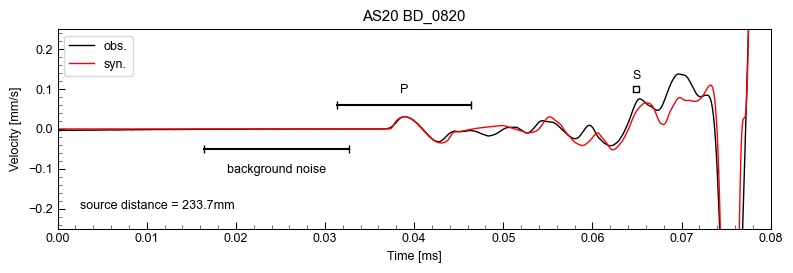

In [52]:
ampfactor_comparison = np.zeros((0, 4))
trcount = 0
theta_evalerr = np.zeros(Nd)
err_evalerr = np.zeros(Nd)

vp = 6200
vs = 3600

hanningwindow = signal.windows.hann(2*smoothing_half_win+1).astype('complex')
hanningwindow /= smoothing_half_win #len(hanningwindow) # divide by half win so that the summation of window weights is unity
print(np.sum(hanningwindow))

# smoothing half width in frequency

dfreq= Y_obs_freq[1] - Y_obs_freq[0]
smooth_half_win_freq = smoothing_half_win * dfreq
print(f"smoothing half win:{smooth_half_win_freq/1e3}kHz")


# for stnm in tqdm(AEsensors):
for stnm in tqdm(AEsensors[19:20]):
    # stnm = AEsensors[11]
    finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform_longpretrig.pickle".format(stnm)) 
    st = read(finame, format="PICKLE")

    # prefilitering traces
    # demean
#     st.detrend(type='demean')
#     # apply bandpass
#     st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)     # NO FILTER for the analysis of attenuation
    # apply taper
#     st.taper(max_percentage=0.001)   

    # Select observation and synthetic
    st_obs = st.select(channel='OY')
    st_syn = st.select(channel='SY')
    
    # Extract the traces used in the Si inversion
    for i, tr_obs in enumerate(st_obs):
        if tr_obs.stats.dataindex not in np.squeeze(df_caseid.values):
            print(tr_obs.stats.dataindex)
            st_obs.remove(tr_obs)
    
    for i, tr_obs in enumerate(st_obs):
            
            if tr_obs.stats.location != selected_BDid:
                continue
            
            dataindex = tr_obs.stats.dataindex
            tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            tvec = np.array(range(0, tr_syn.stats.npts))*tr_syn.stats.delta*1e3 - tr_obs.stats.pretrigger #[ms]

            #---compute correction coefficient from Si, Tj and alpha(theta)---#
            amp_correction = np.zeros(4) # 4 models
            ii, jj = [cij[dataindex][0]-1, cij[dataindex][1]-1]
            kk = df_caseid.index[df_caseid.caseid == dataindex][0]

            Asyn = Aksyn[kk]

            # model 1: gain model
            Si1 = df_Si["model1"][ii]
            amp_correction[0] = Si1

            # model 3: directionality-dominant
            Si3 = df_Si["model3"][ii]
            theta3 = df_disttheta["theta"][kk]
#             alpha3 = model_bell(theta3, 1.0, a3, b3) # bell-shape 
#             amp_correction[1] = Si3*alpha3
            TR3 = df_TR["model3"][0]
            k3 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta3), TR3, R)
            amp_correction[1] = Si3*k3
            #model 2: source impact-dominant
            Si2 = df_Si["model2"][ii]
            Tj2 = df_Tj["model2"][jj]
            amp_correction[2] = Si2*Tj2
            
            # model 4: mix model
            Si4 = df_Si["model4"][ii]
            Tj4 = df_Tj["model4"][jj]
            theta4 = df_disttheta["theta"][kk]
#             alpha4 = model_bell(theta4, 1.0, a4, b4) # bell-shape 
            TR4 = df_TR["model4"][0]
            k4 = incidentangle_scalingfactor_analytic(v, np.deg2rad(theta4), TR4, R)

            amp_correction[3] = Si4*Tj4*k4

#             print((Si4, Tj4, k4))
            ampfactor_comparison = np.vstack((ampfactor_comparison, [df_disttheta["theta"][kk], 
                            amp_correction[3]/amp_correction[0],  amp_correction[3]/amp_correction[1], amp_correction[3]/amp_correction[2]]))
    
            #---------------------------------------------------------------------------------#

            # remove offset and detrend by the first 5 microsec
            st0 = tr_obs.stats.starttime
            pt = timedelta(milliseconds = tr_obs.stats.pretrigger)

            dist = tr_obs.stats.dist #[mm]

            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean

            # trim Pwave
            starttime = st0+pt+(p_theoretical-pwin_len_pre)*1e-3 - pwin_len_margin
            st_P = int(starttime.microsecond*1e-6/tr_obs.stats.delta)
            noise_npts = int(5e-6*tr_obs.stats.sampling_rate)
            for tr in [tr_obs, tr_syn]:
                kp = np.polyfit(tr.times()[st_P:st_P+noise_npts], tr.data[st_P:st_P+noise_npts], 1)
                tr.data -= np.polyval(kp, tr.times())

            # Deprecated: Apply bandpass-filter to mitigate the numerical noise in synthetics
            # just for the sake of ease in visuallization, we apply band-pass filter
            freqmin = 0.06e6
            freqmax = 1e6
            sos = signal.butter(3, [freqmin, freqmax], 'bandpass', fs=tr_obs.stats.sampling_rate, output='sos')
            tr_syn_filtered = tr_syn.copy()
            tr_obs_filtered = tr_obs.copy()
#             tr_syn_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=False)    
#             tr_obs_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=False)    
#             tr_syn_filtered.data = signal.sosfilt(sos, tr_syn_filtered.data)
#             tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)

            fig, ax = plt.subplots(1, 1, figsize=(8, 2.8)) #2.8))
            
#             ax.plot(tvec, 1e3*tr_obs_filtered.data/amp_correction[-1], "k-", label="obs.", lw=1.0)
#             ax.plot(tvec, 1e3*tr_syn_filtered.data, 'r-', label="syn.", lw=1.0)

            # plot raw data
            ax.plot(tvec, 1e3*tr_obs.data/amp_correction[-1], "k-", label="obs.", lw=1.0)
            ax.plot(tvec+N_shift*tr_syn.stats.delta*1e3, 1e3*tr_syn.data, 'r-', label="syn.", lw=1.0)
          
            ax.set_xlabel("Time [ms]")
            ax.set_ylabel("Velocity [mm/s]")
            
            ax.set_xlim([0, 0.08]) #[0.035, 0.05])
#             ax.set_xlim([0.04, 0.06])
            
#             ax1.set_ylim(ylimit_wf_p)
            ylimit = [-0.25, 0.25]
            ax.set_ylim(ylimit)
#             ax.set_ylim([-0.001, 0.001])
    
            #----------------------------------#
            # annotate arrival times and window
            #----------------------------------#

            dist = tr_obs_filtered.stats.dist
            tp = dist/vp
            ts = dist/vs
            if dist <= dist_p_threshold:
                p_theoretical = tr_obs.stats.tpick
            else:
                p_theoretical = dist/vmean
                
#             ax.plot(tr_obs_trim_PLT.stats.dist/param["cp"], arrivaltime_y-i, "v", ms=5.5, mec="k", mfc="w")
#     ax.plot(tr_obs_trim_PLT.stats.dist/param["cs"], arrivaltime_y-i, "s", ms=5, mec="k", mfc="w")
#             ax.plot(tp, 0.3, "v", ms=5.5, mec="k", mfc="w")
            ax.plot(ts, 0.1, "s", ms=5, mec="k", mfc="w")
#             ax.text(tp, 0.35, "P", ha="center")
            ax.text(ts, 0.125, "S", ha="center")
            
            # trimmed windows
            
            st0 = tr_obs.stats.starttime
            pt = timedelta(milliseconds = tr_obs.stats.pretrigger)
            
            centralize_tshift = Ncentralize * tr_obs.stats.delta # observed and synthetic waveforms are shifted to centralize the first peak
            p_starttime = (p_theoretical-pwin_len_pre)*1e-3 + centralize_tshift
            p_endtime = (p_theoretical-pwin_len_pre+pwin_len)*1e-3 + centralize_tshift
            
            bar_y = 0.06
            ax.plot(np.array([p_starttime, p_endtime])*1e3, np.array([bar_y, bar_y]), "k-", marker="|" )
            ax.text((p_starttime+p_endtime)*1e3/2, 0.09, "P", ha="center")
#             ax.plot((p_starttime+p_endtime)*1e3/2, 0.175, "o")
#             ax.axhline(0.04)

            # trim synthetic data
            tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
            tr_syn_trim.trim(starttime, endtime, pad=True, fill_value=0.0)

            # trim the observation noise
            noise_start_time = p_starttime - noise_winlen
            noise_end_time = p_theoretical*1e-3-noise_Pbackward
            
            bar_y_noise = -0.05
            ax.plot(np.array([noise_start_time, noise_end_time])*1e3, np.array([bar_y_noise, bar_y_noise]), "k-", marker="|" )
            ax.text((noise_start_time+noise_end_time)*1e3/2, -0.11, "background noise", ha="center")
            
            ax.set_title(f"AS{tr_obs.stats.station[2:]} {tr_obs.stats.dataindex[6:]}")
            
            ax.legend(loc=2)
            ax.text(0.0025, -0.2, f"source distance = {tr_obs_trim.stats.dist:.1f}mm")

            
            plt.tight_layout()


            plt.savefig(figdir_Bomega+"/trace_master_computeBomega_{}.png".format(dataindex), format="png", dpi=150, bbox_inches="tight")
            plt.savefig(figdir_Bomega+"/trace_master_computeBomega_{}.eps".format(dataindex), format="eps", bbox_inches="tight")

